# Introduction
[Data Description](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)


You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
```
toxic
severe_toxic
obscene
threat
insult
identity_hate
```
You must create a model which predicts a probability of each type of toxicity for each comment.


# Imports

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
plt.style.use('ggplot') # better than sns styles.
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time

# random state
SEED=100
np.random.seed(SEED)

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
from pandas.api.types import CategoricalDtype
np.set_printoptions(precision=3)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 500)

import IPython
from IPython.display import display, HTML, Image, Markdown

print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.17.4'), ('pandas', '0.25.3'), ('seaborn', '0.9.0'), ('matplotlib', '3.1.1')]


In [0]:
import re
import string # string.punctuation
import string
from string import digits

In [12]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
ENV_BHISHAN = None

try:
    import bhishan
    ENV_BHISHAN = True
    print("Environment: Bhishan's Laptop")
except:
    pass


import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # load google drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    # dat_dir = 'drive/My Drive/Colab Notebooks/data/' 
    # sys.path.append(dat_dir)
    
    # pip install
    #!pip install pyldavis
    #!pip install hyperopt
    #!pip install catboost

    # upgrade tqdm and restart to use df.progess_apply()
    # !pip install -U tqdm
    
    # print
    print('Environment: Google Colaboratory.')

Environment: Google Colaboratory.


In [0]:
import scipy

In [0]:
# pipeline
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, ClassifierMixin

In [0]:
# text features
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# classifiers
from sklearn.linear_model import LogisticRegression


In [0]:
# model selection
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Useful Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

# Load the Data

In [18]:
ifile1_train = '../data/raw/train.csv'
ifile2_train = 'https://github.com/bhishanpdl/Project_Toxic_Comments/blob/master/data/raw/train.csv?raw=true'

ifile1_test = '../data/raw/test.csv'
ifile2_test = 'https://github.com/bhishanpdl/Project_Toxic_Comments/blob/master/data/raw/test.csv?raw=true'

if ENV_BHISHAN:
    df_raw_train = pd.read_csv(ifile1_train)
    df_raw_test = pd.read_csv(ifile1_test)


if ENV_COLAB:
    df_raw_train = pd.read_csv(ifile2_train)
    df_raw_test = pd.read_csv(ifile2_test)
    pass


df_train = df_raw_train.copy()
df_test = df_raw_test.copy()

print(df_train.shape)
df_train.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [19]:
print(df_test.shape)
df_test.head()

(153164, 2)


,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [22]:
df_train['clean'] = df_train.loc[:,'toxic':'identity_hate'].sum(axis=1) == 0

print(df_train['clean'].sum())

df_train.head(2)

143346


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,True
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,True


# Class distribution

In [20]:
ser_sum = df_train.iloc[:,2:].sum(axis=0)
ser_sum

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

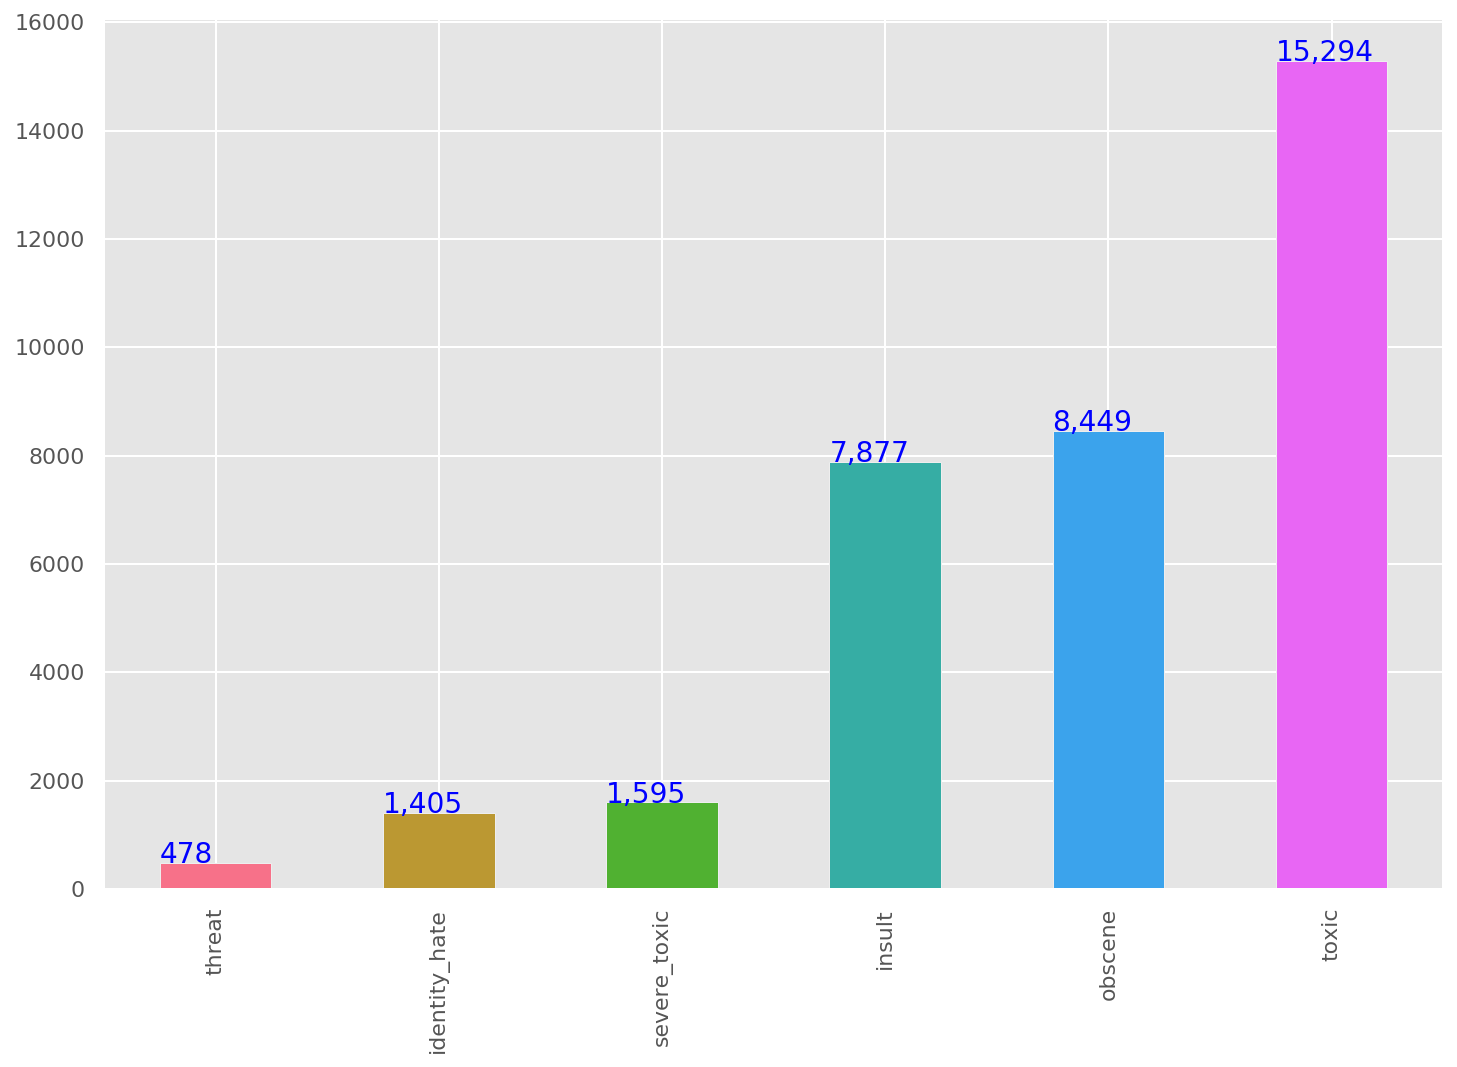

In [21]:
ax = ser_sum.sort_values().plot.bar(color=sns.color_palette('husl',len(ser_sum)))

for p in ax.patches:
    x,y = p.get_x(), p.get_height()
    ax.text(x,y,f'{y:,.0f}',fontsize=14,color='blue')

# Train Target Split

In [24]:
Xtrain = df_train.loc[:5000, 'comment_text'].to_numpy()
ytrain = df_train.loc[:5000, 'toxic'].to_numpy()

ytrain[:5]

array([0, 0, 0, 0, 0])

# Text Modelling: Logistic Regression

In [0]:
# default params
scoring='roc_auc'
cv=3
n_jobs=-1
max_features = 2500

## Baseline Logistic Regression

In [27]:
tfidf = TfidfVectorizer(max_features=max_features)
lr = LogisticRegression()
p = Pipeline([
    ('tfidf', tfidf),
    ('lr', lr)
])

cvs = cross_val_score(estimator=p, X=Xtrain, y=ytrain, scoring=scoring, cv=cv, n_jobs=n_jobs)

cvs.mean().round(4)

0.9226

## Model 2: NBFeaturer

In [0]:
import scipy

class NBFeaturer(BaseEstimator):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    def pr(self, x, y_i, y):
        p = x[y==y_i].sum(0)
        return (p+self.alpha) / ((y==y_i).sum()+self.alpha)

    def fit(self, x, y=None):
        self._r = scipy.sparse.csr_matrix(np.log(self.pr(x,1,y) / self.pr(x,0,y)))
        return self
    
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [34]:
tfidf = TfidfVectorizer(max_features=max_features)
lr = LogisticRegression()
nb = NBFeaturer(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

cvs = cross_val_score(estimator=p, X=Xtrain, y=ytrain, scoring=scoring, cv=cv, n_jobs=n_jobs)
cvs.mean().round(4)

0.9246

# Model 3: NBFeaturer + Lemmatizer

In [0]:
class Lemmatizer(BaseEstimator):
    def __init__(self):
        self.l = WordNetLemmatizer()
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        x = map(lambda r:  ' '.join([self.l.lemmatize(i.lower()) for i in r.split()]), x)
        x = np.array(list(x))
        return x

In [36]:
lm = Lemmatizer()
tfidf = TfidfVectorizer(max_features=max_features)
lr = LogisticRegression()
nb = NBFeaturer(1)

p = Pipeline([
    ('lm', lm),
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

cvs = cross_val_score(estimator=p, X=Xtrain, y=ytrain, scoring=scoring, cv=cv, n_jobs=n_jobs)
cvs.mean().round(4)

0.9258

## Model 4: NBFeaturer + Lemmatizer + two tfidfs

In [37]:
max_features = 2500
lm = Lemmatizer()
tfidf_w = TfidfVectorizer(max_features=max_features, analyzer='word')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lr = LogisticRegression()
nb = NBFeaturer(1)

p = Pipeline([
    ('lm', lm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('nb', nb),
    ('lr', lr)
])

cvs = cross_val_score(estimator=p, X=Xtrain, y=ytrain, scoring=scoring, cv=cv, n_jobs=n_jobs)
cvs.mean().round(4)

0.9369

## Grid Search

In [38]:
param_grid = [{
    'wc_tfidfs__tfidf_w__max_features': [2500], 
    'wc_tfidfs__tfidf_c__stop_words': [2500, 5000],
    'lr__C': [3.],
}]

grid = GridSearchCV(p, cv=cv, n_jobs=n_jobs, param_grid=param_grid, scoring=scoring, 
                            return_train_score=False, verbose=0)
grid.fit(Xtrain, ytrain)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('lm', Lemmatizer()),
                                       ('wc_tfidfs',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('tfidf_w',
                                                                        TfidfVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.float64'>,
                                                                                        encoding='utf-8',
                                                                                        input='co

In [39]:
param_grid = [{
    'wc_tfidfs__tfidf_w__max_features': [2500, 5000, 10000], 
    'wc_tfidfs__tfidf_c__stop_words': [2500, 5000, 10000],
    'lr__C': [1., 3., 4.],
}]

grid = RandomizedSearchCV(p, cv=cv, n_jobs=n_jobs, param_distributions=param_grid[0], n_iter=1, 
                          scoring=scoring, return_train_score=False, verbose=1)
grid.fit(Xtrain, ytrain)
grid.cv_results_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'mean_fit_time': array([3.835]),
 'mean_score_time': array([1.034]),
 'mean_test_score': array([0.933]),
 'param_lr__C': masked_array(data=[3.0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_wc_tfidfs__tfidf_c__stop_words': masked_array(data=[2500],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_wc_tfidfs__tfidf_w__max_features': masked_array(data=[2500],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'lr__C': 3.0,
   'wc_tfidfs__tfidf_c__stop_words': 2500,
   'wc_tfidfs__tfidf_w__max_features': 2500}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.931]),
 'split1_test_score': array([0.94]),
 'split2_test_score': array([0.928]),
 'std_fit_time': array([1.74]),
 'std_score_time': array([0.245]),
 'std_test_score': array([0.005])}

In [41]:
show_method_attributes(grid)

Object Type: <class 'sklearn.model_selection._search.RandomizedSearchCV'>



,0,1,2,3,4,5,6
0,best_estimator_,cv,fit,n_iter,predict,refit_time_,scoring
1,best_index_,cv_results_,get_params,n_jobs,predict_log_proba,return_train_score,set_params
2,best_params_,decision_function,iid,n_splits_,predict_proba,score,transform
3,best_score_,error_score,inverse_transform,param_distributions,random_state,scorer_,verbose
4,classes_,estimator,multimetric_,pre_dispatch,refit,,


In [43]:
grid.best_params_

{'lr__C': 3.0,
 'wc_tfidfs__tfidf_c__stop_words': 2500,
 'wc_tfidfs__tfidf_w__max_features': 2500}